In [3]:
import pandas as pd
import numpy as np

## preprocessing

In [4]:
df = pd.read_excel("data/lapi1121.xlsx")
df.state = df.state.fillna(method='ffill')
df = df.replace('--',np.nan)
df = df.dropna()

## Pytorch Kmeans

In [7]:

import torch
import numpy as np
from kmeans_pytorch import kmeans

# data
num_clusters =5
x = df[['per_capita_2018', 'per_capita_2019',
       'per_capita_2020']].values.astype(float)
x = torch.from_numpy(x)

# kmeans
cluster_ids_x, cluster_centers = kmeans(
    X=x, num_clusters=num_clusters, distance='euclidean', device=torch.device('cpu'), seed=2
)

df["cluster"] = cluster_ids_x

running k-means on cpu..


[running kmeans]: 43it [00:00, 582.03it/s, center_shift=0.000000, iteration=43, tol=0.000100]        

device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu
device is :cpu


## sklearn Kmeans

In [11]:
from sklearn.cluster import KMeans
k =5
X = df[['per_capita_2018', 'per_capita_2019',
       'per_capita_2020']].values.astype(float)

kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
kmeansThree = KMeans(n_clusters=3, random_state=0).fit(X)
kmeansFive = KMeans(n_clusters=5, random_state=0).fit(X)

print(kmeans.labels_)
print(kmeans.cluster_centers_)

#sort clusters for color coding later 
idx = np.argsort(kmeans.cluster_centers_.mean(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)
print(lut[kmeans.labels_])

df["cluster"] = lut[kmeans.labels_]



[3 3 1 ... 3 0 3]
[[ 53826.61574803  55733.71181102  60026.2976378 ]
 [ 33946.92394366  35235.78403756  38382.06760563]
 [ 75241.50381679  77481.38167939  80860.21374046]
 [ 42820.65901899  44384.76898734  48009.20411392]
 [133446.8125     138409.4375     141415.0625    ]]
[1 1 0 ... 1 2 1]


### Elbow Method

In [5]:
# kmeans with different k to do the Elbow method
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

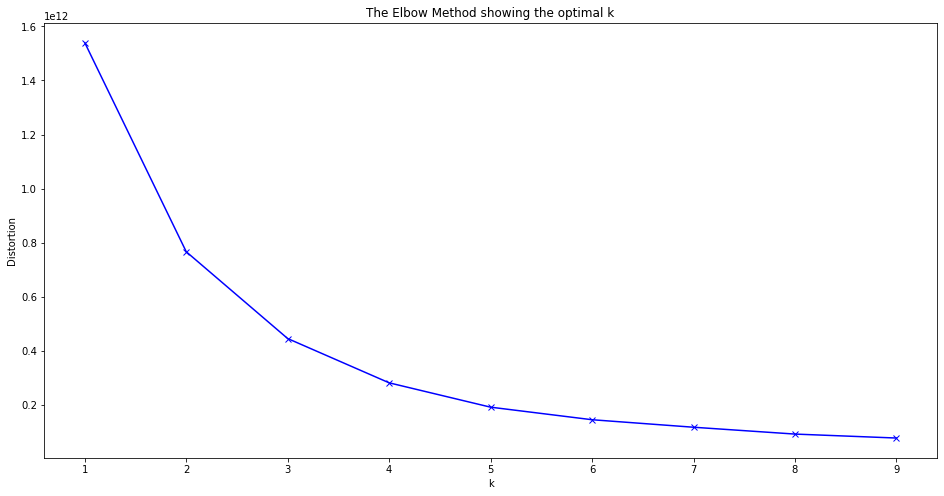

In [8]:
# it seems that k=3 or k=5 are the optimal values 
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Silhoutte Score

In [9]:
# the silhoutte score proposes k=3
from sklearn import metrics

print(
    "Silhouette Coefficient K=3: %0.3f"
    % metrics.silhouette_score(X, kmeansThree.labels_, metric="sqeuclidean")
)

print(
    "Silhouette Coefficient K=5: %0.3f"
    % metrics.silhouette_score(X, kmeansFive.labels_, metric="sqeuclidean")
)

Silhouette Coefficient K=3: 0.711
Silhouette Coefficient K=5: 0.674


# analyse results

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile = gpd.read_file("data/cb_2018_us_county_20m/cb_2018_us_county_20m.shp")

df_fips = pd.DataFrame([
['Alabama',	"AL"	,"01"],
['Alaska',	'AK',	'02'],
['Arizona',	'AZ'	,'04'],
['Arkansas',	'AR',	'05'],
['California',	'CA',	'06'],
['Colorado',	'CO',	'08'],
['Connecticut',	'CT',	'09'],
['Delaware',	'DE',	'10'],
['Florida',	'FL',	'12'],
['Georgia',	'GA',	'13'],
['Hawaii',	'HI',	'15'],
['Idaho',	'ID',	'16'],
['Illinois',	'IL',	'17'],
['Indiana',	'IN',	'18'],
['Iowa',	'IA',	'19'],
['Kansas',	'KS',	'20'],
['Kentucky',	'KY',	'21'],
['Louisiana',	'LA',	'22'],
['Maine',	'ME',	'23'],
['Maryland',	'MD',	'24'],
['Massachusetts',	'MA',	'25'],
['Michigan',	'MI',	'26'],
['Minnesota',	'MN',	'27'],
['Mississippi',	'MS',	'28'],
['Missouri',	'MO',	'29'],
['Montana',	'MT',	'30'],
['Nebraska',	'NE',	'31'],
['Nevada',	'NV',	'32'],
['New Hampshire',	'NH',	'33'],
['New Jersey',	'NJ',	'34'],
['New Mexico',	'NM',	'35'],
['New York',	'NY',	'36'],
['North Carolina',	'NC',	'37'],
['North Dakota',	'ND',	'38'],
['Ohio',	'OH',	'39'],
['Oklahoma',	'OK',	'40'],
['Oregon',	'OR',	'41'],
['Pennsylvania',	'PA',	'42'],
['Rhode Island',	'RI',	'44'],
['South Carolina',	'SC',	'45'],
['South Dakota',	'SD',	'46'],
['Tennessee',	'TN',	'47'],
['Texas',	'TX',	'48'],
['Utah',	'UT',	'49'],
['Vermont',	'VT',	'50'],
['Virginia',	'VA',	'51'],
['Washington',	'WA',	'53'],
['West Virginia',	'WV', '54'],
['Wisconsin',	'WI',	'55'],
['Wyoming',	'WY',	'56'],
], columns=["stateName", "statePostalCode", "stateFIPS"])
print(shapefile.shape)
shapefile = shapefile.merge(df_fips, left_on="STATEFP", right_on="stateFIPS")
print(shapefile.shape)
shapefile = shapefile[shapefile.stateName!='Alaska']
print(shapefile.shape)
shapefile = shapefile.merge(df, left_on=['stateName', 'NAME'], right_on=['state', 'County'], how="left")
shapefile =shapefile.fillna("-1")
print(shapefile.shape)
#add color coding
clusterList = list(range(0,k))
clusterList.insert(k,"-1")
from colour import Color
red = Color("red")
colorList = list(red.range_to(Color("green"),k))
colorListRgb = []
for i in colorList:
    colorListRgb.append(i.hex)
colorListRgb.append("#000000")
df_colours = pd.DataFrame([clusterList, colorListRgb]).T
df_colours.columns = ['cluster','rgb_cluster']
shapefile = shapefile.merge(df_colours, left_on='cluster', right_on='cluster')

(3220, 10)
(3141, 13)
(3112, 13)
(3112, 23)


In [11]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("test", colorListRgb, N=len(colorListRgb))

<AxesSubplot:>

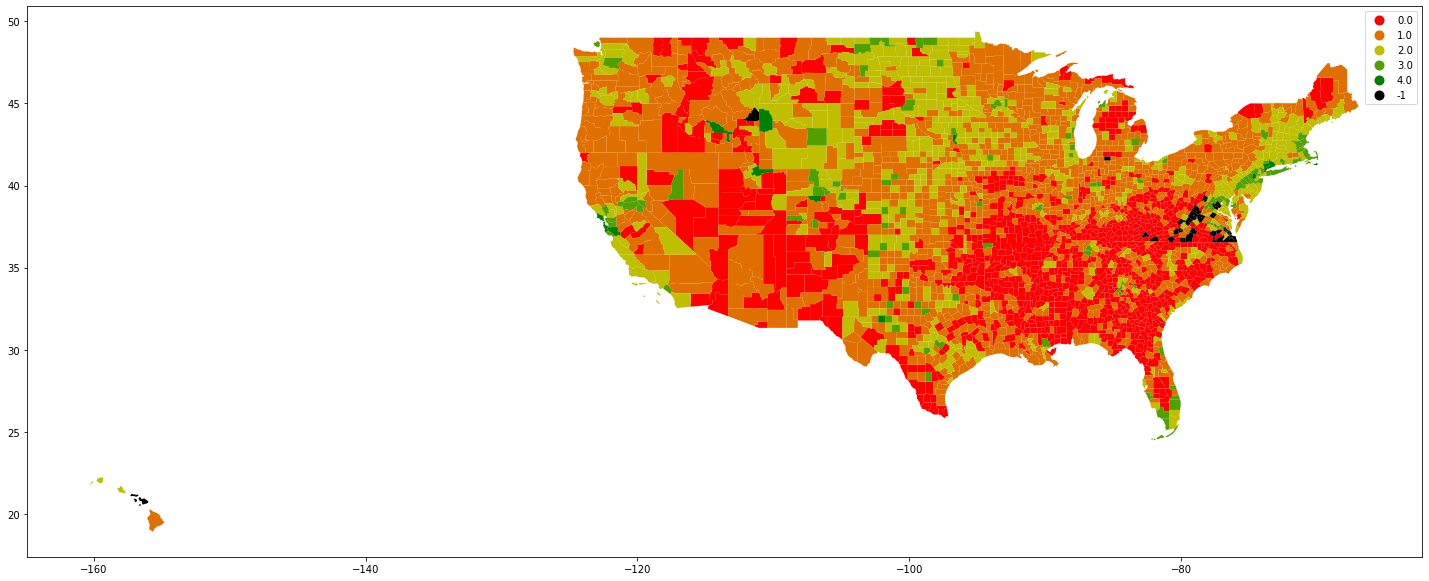

In [12]:
shapefile.plot(
    figsize=(25,25),
    column='cluster',
    categorical=True,
    legend=True,
    cmap=cmap,
    )

<AxesSubplot:>

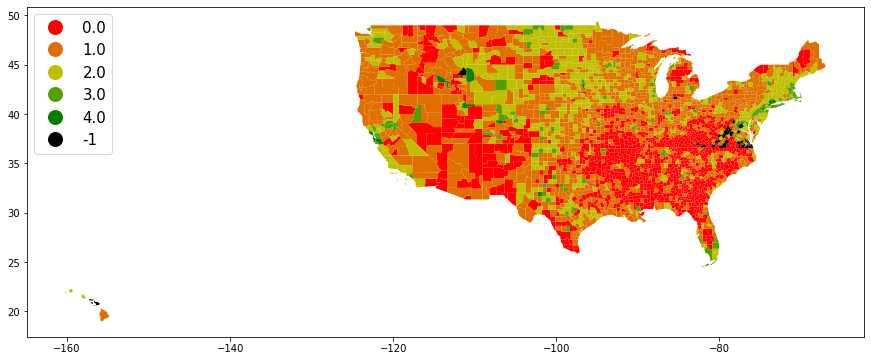

In [103]:
fig, ax = plt.subplots(figsize=(15,15))

shapefile.plot(ax=ax,
    #figsize=(50,50),
    column='cluster',
    categorical=True,
    legend=True,
    cmap=cmap,
     legend_kwds={
    #     "labels":[1,2,3,4,5,6],
         'loc':'upper left',
                  "fontsize":15,
                  "markerscale":1.5,
                 }
    )

# Adjust legend location
#leg = ax.get_legend()
#leg.set_label([123,12,123,2123,123])

#leg.legend(loc='lower left')
#leg.set_bbox_to_anchor(0)
#ax.legend(['A simple line'],fo)
#ax.set_axis_off()
#ax.legend(["asdas","asdas","asdas","asdas","asdas","asdas"])
#plt.show()